# Data Analysis

This will be the first step on the search for a good Machine Learning algorithm to be applied on our data set.

Our data set consists of data captured from 20/09/2017 til 29/10/2017, on a hallway. Both relays were connected to lights. Relay 1's light was on the same environment to which the luminosity sensor was placed.

The following parameters is what we have for each data entry:
- date/time
- luminosity
- temperature
- humidity
- presence
- relay activation
- type of activation (via button, website, remote control or automatic scheduling)
- relay status

In [2]:
import datetime
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
import matplotlib
 
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier

sns.set_style('whitegrid')
        
matplotlib.rcParams['savefig.dpi'] = 160
matplotlib.rcParams['figure.dpi'] = 160

In [3]:
 ml_data_path = 'log_corredor.csv'

In [4]:
ml_data = pd.read_csv(ml_data_path, skiprows=4)

print(len(ml_data))

11793


In [5]:
def to_seconds(hours):
    [hours, minutes, seconds] = [int(x) for x in hours.split(':')]
    x = datetime.timedelta(hours=hours, minutes=minutes, seconds=seconds)
    return x.seconds

rele1_timestamps_activated = [ data[0].split()[0] for index, data in ml_data.iterrows() if data[50] == 1]
rele1_hours_activated = [ to_seconds(data[4]) for index, data in ml_data.iterrows() if data[50] == 1]
rele1_hours_turned_on = [ to_seconds(data[4]) for index, data in ml_data.iterrows() if data['Rele1'] == 1]
rele1_hours_turned_off = [ to_seconds(data[4]) for index, data in ml_data.iterrows() if data['Rele1'] == 0]
print(len(rele1_timestamps_activated))
print(len(rele1_hours_turned_on))

rele2_timestamps_activated = [ data[0].split()[0] for index, data in ml_data.iterrows() if data[52] == 1]
rele2_hours_activated = [ to_seconds(data[4]) for index, data in ml_data.iterrows() if data[52] == 1]
rele2_hours_turned_on = [ to_seconds(data[4]) for index, data in ml_data.iterrows() if data['Rele2'] == 1]
rele2_hours_turned_off = [ to_seconds(data[4]) for index, data in ml_data.iterrows() if data['Rele2'] == 0]
print(len(rele2_timestamps_activated))
print(len(rele2_hours_turned_on))

238
3766
202
2450


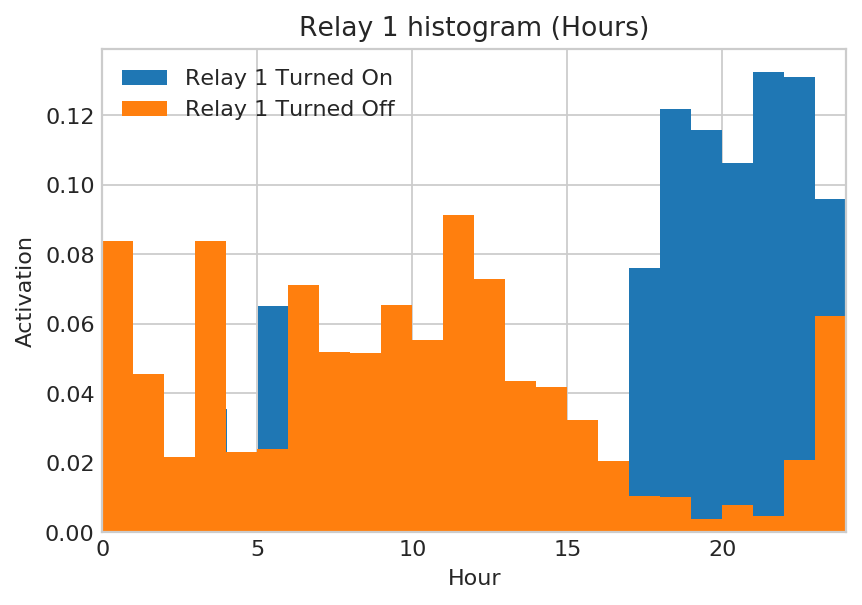

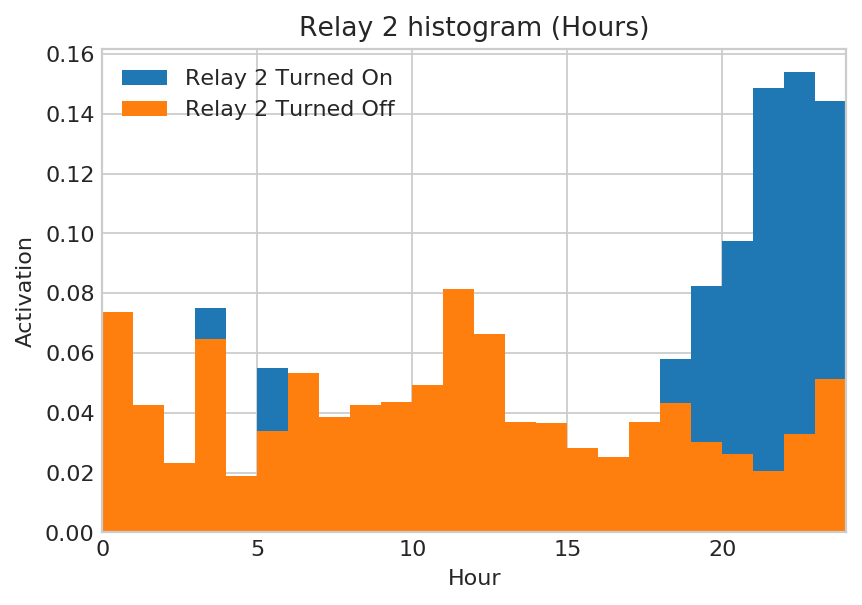

In [6]:
rele1_only_hours_turned_on = [hour/3600 for hour in rele1_hours_turned_on]
rele1_only_hours_turned_off = [hour/3600 for hour in rele1_hours_turned_off]
plt.xlim(0, 24)
plt.hist(rele1_only_hours_turned_on, bins=24, normed=True, label = 'Relay 1 Turned On')
plt.hist(rele1_only_hours_turned_off, bins=24, normed=True, label = 'Relay 1 Turned Off')
plt.title('Relay 1 histogram (Hours)')
plt.xlabel('Hour')
plt.ylabel('Activation')
plt.legend()
plt.show()

rele2_only_hours_turned_on = [hour/3600 for hour in rele2_hours_turned_on]
rele2_only_hours_turned_off = [hour/3600 for hour in rele2_hours_turned_off]
plt.xlim(0, 24)
plt.hist(rele2_only_hours_turned_on, bins=24, normed=True, label = 'Relay 2 Turned On')
plt.hist(rele2_only_hours_turned_off, bins=24, normed=True, label = 'Relay 2 Turned Off')
plt.title('Relay 2 histogram (Hours)')
plt.xlabel('Hour')
plt.ylabel('Activation')
plt.legend()
plt.show()

In [7]:
data = ml_data.iloc[28]
print(data)

Dado Bruto Unix Time                 1505058063 Web1 acionado
Dado Bruto DateTime                           10/9/17 12:41:3
Dado Bruto                  10/09/2017 12:41:03 Web1 acionado
Data                                               10/09/2017
Hora                                                 12:41:03
Info                                            Web1 acionado
ChipId                                                    NaN
Versao =                                              170906b
Unnamed: 8                                                  0
localPingErrCnt:                                          NaN
WiFi Conectando                                             0
WL_DISCONNECTED                                           NaN
minFreeHeap                                               NaN
ms                                                        NaN
NTP Server                                                  0
TimeNTP                                                     0
tempo pa

In [12]:
luminosity_right_before_rele1_turn_on = [ data[24] 
                                         for index, data in ml_data.iterrows() 
                                         if ml_data.iloc[index-1]['Rele1'] == 0 and data[50] == 1]
# print(luminosity_right_before_rele1_turn_on)
print(len(luminosity_right_before_rele1_turn_on))

# we must exclude the automatic activations
luminosity_right_before_rele1_turn_on = [ data[24] 
                                         for index, data in ml_data.iterrows() 
                                         if ml_data.iloc[index-1]['Rele1'] == 0 and data[50] == 1 and ml_data.iloc[index-1][34] != 1]
# print(luminosity_right_before_rele1_turn_on)
print(len(luminosity_right_before_rele1_turn_on))

118
71


In [17]:
features_rele1_turn_on = [[data[24], to_seconds(data[4])] 
                          for index, data in ml_data.iterrows() 
                          if data['Rele1'] == 1 and data[50] == 1 and ml_data.iloc[index-1][34] != 1]
# data[34] is automatic turn on
# print(features_rele1_turn_on)
print(len(features_rele1_turn_on))

features_rele2_turn_on = [[data[24], to_seconds(data[4])] 
                          for index, data in ml_data.iterrows() 
                          if ml_data.iloc[index-1]['Rele2'] == 0 and data[52] == 1 and ml_data.iloc[index-1][36] != 1]
print(len(features_rele2_turn_on))

71
100


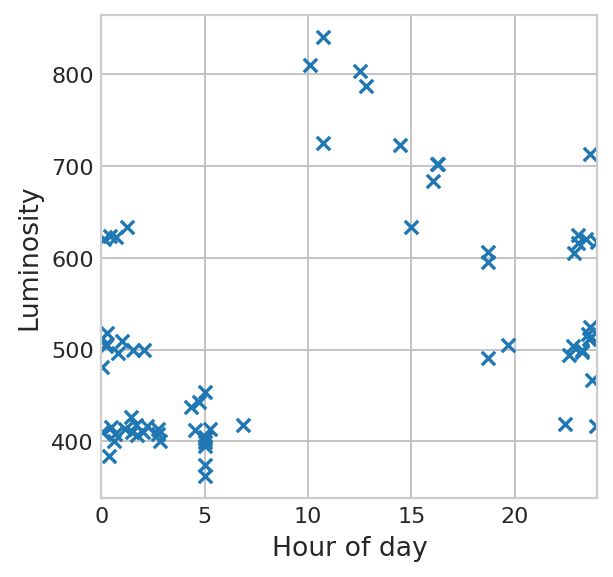

In [15]:
features_rele1_turn_on = np.array(features_rele1_turn_on)
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

ax.set_xlim([0,24])
ax.set_xlabel("Hour of day",fontsize=12)
ax.set_ylabel("Luminosity",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

ax.scatter(features_rele1_turn_on[:, 1]/3600, 
           features_rele1_turn_on[:, 0], 
           marker = 'x');

plt.show()

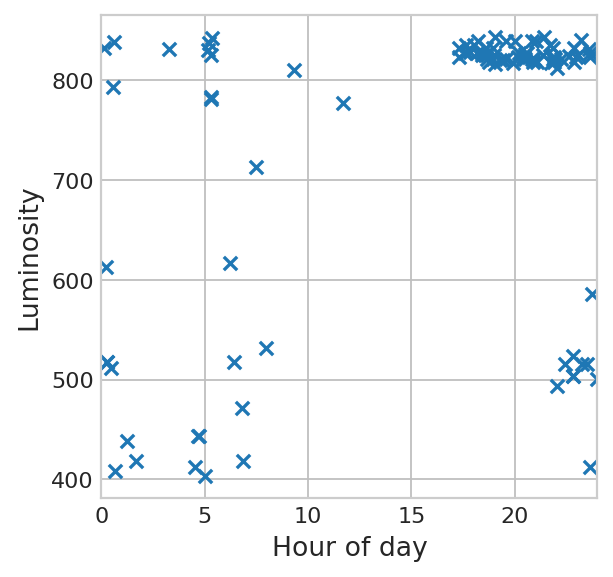

In [16]:
features_rele2_turn_on = np.array(features_rele2_turn_on)
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

ax.set_xlim([0,24])
ax.set_xlabel("Hour of day",fontsize=12)
ax.set_ylabel("Luminosity",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

ax.scatter(features_rele2_turn_on[:, 1]/3600, 
           features_rele2_turn_on[:, 0], 
           marker = 'x');

plt.show()

# Model Training and Testing

In [37]:
from itertools import *

features = []
activation_bool = []

def was_activated(activation):
    if activation == 1:
        return True
    return False

def get_presence_as_int(presence_data):
    if presence_data == 1:
        return presence_data
    return 0

# we will skip first 1057 rows, because those do not have info on rele1 status
for index, data in islice(ml_data.iterrows(), 1057, None):
    # we do not want to consider it if the light was already on, or if the activation was automatic (scheduled)
    if index == 0 or ml_data.iloc[index-1]['Rele1'] == 1 or ml_data.iloc[index-1][34] == 1:
        continue
    
    # will discard nan values
    if np.isnan(data[24]) or np.isnan(data[26]) or np.isnan(data[28]):
        continue
    
    features.append([to_seconds(data[4]),
                     data[24], # Luminosity
                     data[26], # Temperature
                     data[28], # Humidity
                     get_presence_as_int(data[30]), # Presence
                    ]) 
    activation_bool.append(was_activated(data[50]))

print(len(features))
print(len(activation_bool))
features = np.array(features)
activation_bool = np.array(activation_bool)\

6922
6922


In [38]:
# splitting data set between training and testing:
X_train, X_test, y_train, y_test = train_test_split(features, activation_bool, test_size=0.33)

In [39]:
# TODO need to carefully review which classifiers to be picked
classifiers = [BernoulliNB(),  
               LogisticRegression(), 
               SVC(), 
               MultinomialNB(), 
               Perceptron(),
               PassiveAggressiveClassifier(),
               MLPClassifier()]

metrics = []

for classifier in classifiers:
    # here we train
    model = classifier.fit(X_train, y_train)
    
    # here we test
    y_pred = model.predict(X_test)
    y_true = y_test
    
    # here we check performance
    report = classification_report(y_true, y_pred, digits=2)
        
    metrics.append((model, 
                   model.score(X_test, y_test), 
                   model.score(X_train, y_train),
                   report))

metrics.sort(key=lambda x: x[1], reverse=True)

print([(metric[0].__class__.__name__, metric[1], metric[2]) for metric in metrics])

# Best classifier
best_clf = metrics[0][0]

/home/gabi/envs/ML/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gabi/envs/ML/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/gabi/envs/ML/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, t

[('BernoulliNB', 0.99212253829321662, 0.98857019624757381), ('LogisticRegression', 0.99212253829321662, 0.98857019624757381), ('Perceptron', 0.99212253829321662, 0.98857019624757381), ('PassiveAggressiveClassifier', 0.99212253829321662, 0.98857019624757381), ('SVC', 0.98687089715536103, 0.99158938969161092), ('MLPClassifier', 0.96411378555798688, 0.95945654518007328), ('MultinomialNB', 0.75842450765864333, 0.74638775070088414)]
